In [1]:
# Get the names dataset

import pandas as pd
names = open("human_names.txt").read().splitlines()
names = pd.read_csv("98-505-X2021007_eng_csv_data.csv").sort_values('GENDER_TOTAL_COUNT').head(500)
names = names["FIRST_NAME"].astype(str)




In [2]:
# Get vocab
import string
from collections import defaultdict

# filter names for typical chars
names = [name.lower() for name in names]
names = [name for name in names if set(name) <= set(string.ascii_lowercase)]
chars = set("".join(names).lower())
num_chars = len(chars)
assert '#' not in chars

# discretize characters to numbers for easier training
chars = list(sorted(chars))
chars = ["#"] + chars
itos = {idx: c for idx, c in enumerate(chars)}
stoi = {c: idx for idx, c in itos.items()}
vocab_size = len(chars)

# Train the model on bigrams
d = defaultdict(int)
for name in names:
    name = "#" + name + "#"
    for c1, c2 in zip(name, name[1:]):
        d[(c1,c2)] += 1
tups = sorted(d.items(), key=lambda x: -x[1])





In [3]:
import torch
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)
for (c1,c2), count in d.items():
    N[stoi[c1], stoi[c2]] = count
print(N)

tensor([[  0,  57,  19,  21,  28,  19,  15,   8,  17,  10,  27,  24,  22,  45,
          18,   6,  13,   1,  26,  46,  28,   2,   6,   9,   3,   9,  12],
        [104,   4,  13,   7,  24,   8,   3,   3,  12,  17,   6,  12,  27,  24,
          76,   3,   1,   1,  50,  15,  13,   6,  11,   6,   3,  12,   3],
        [  1,   8,   0,   0,   4,   7,   0,   0,   2,   4,   0,   0,   1,   0,
           0,   4,   0,   0,   8,   2,   0,   2,   0,   0,   0,   1,   0],
        [  1,   4,   0,   0,   0,   4,   0,   0,  17,   5,   1,   2,   4,   0,
           0,   9,   0,   0,   2,   0,   1,   1,   0,   0,   0,   1,   1],
        [ 21,  26,   0,   0,   2,  19,   0,   0,   5,  11,   2,   0,   0,   1,
           1,  10,   0,   0,   6,   0,   0,   4,   0,   0,   0,   7,   0],
        [ 60,   7,   2,   1,   7,  10,   1,   2,   5,  11,   0,   3,  35,  10,
          31,   1,   2,   1,  36,  12,  12,   2,   6,   1,   1,   2,   2],
        [  1,   7,   0,   0,   0,   6,   1,   0,   0,   6,   0,   0,   3,   

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

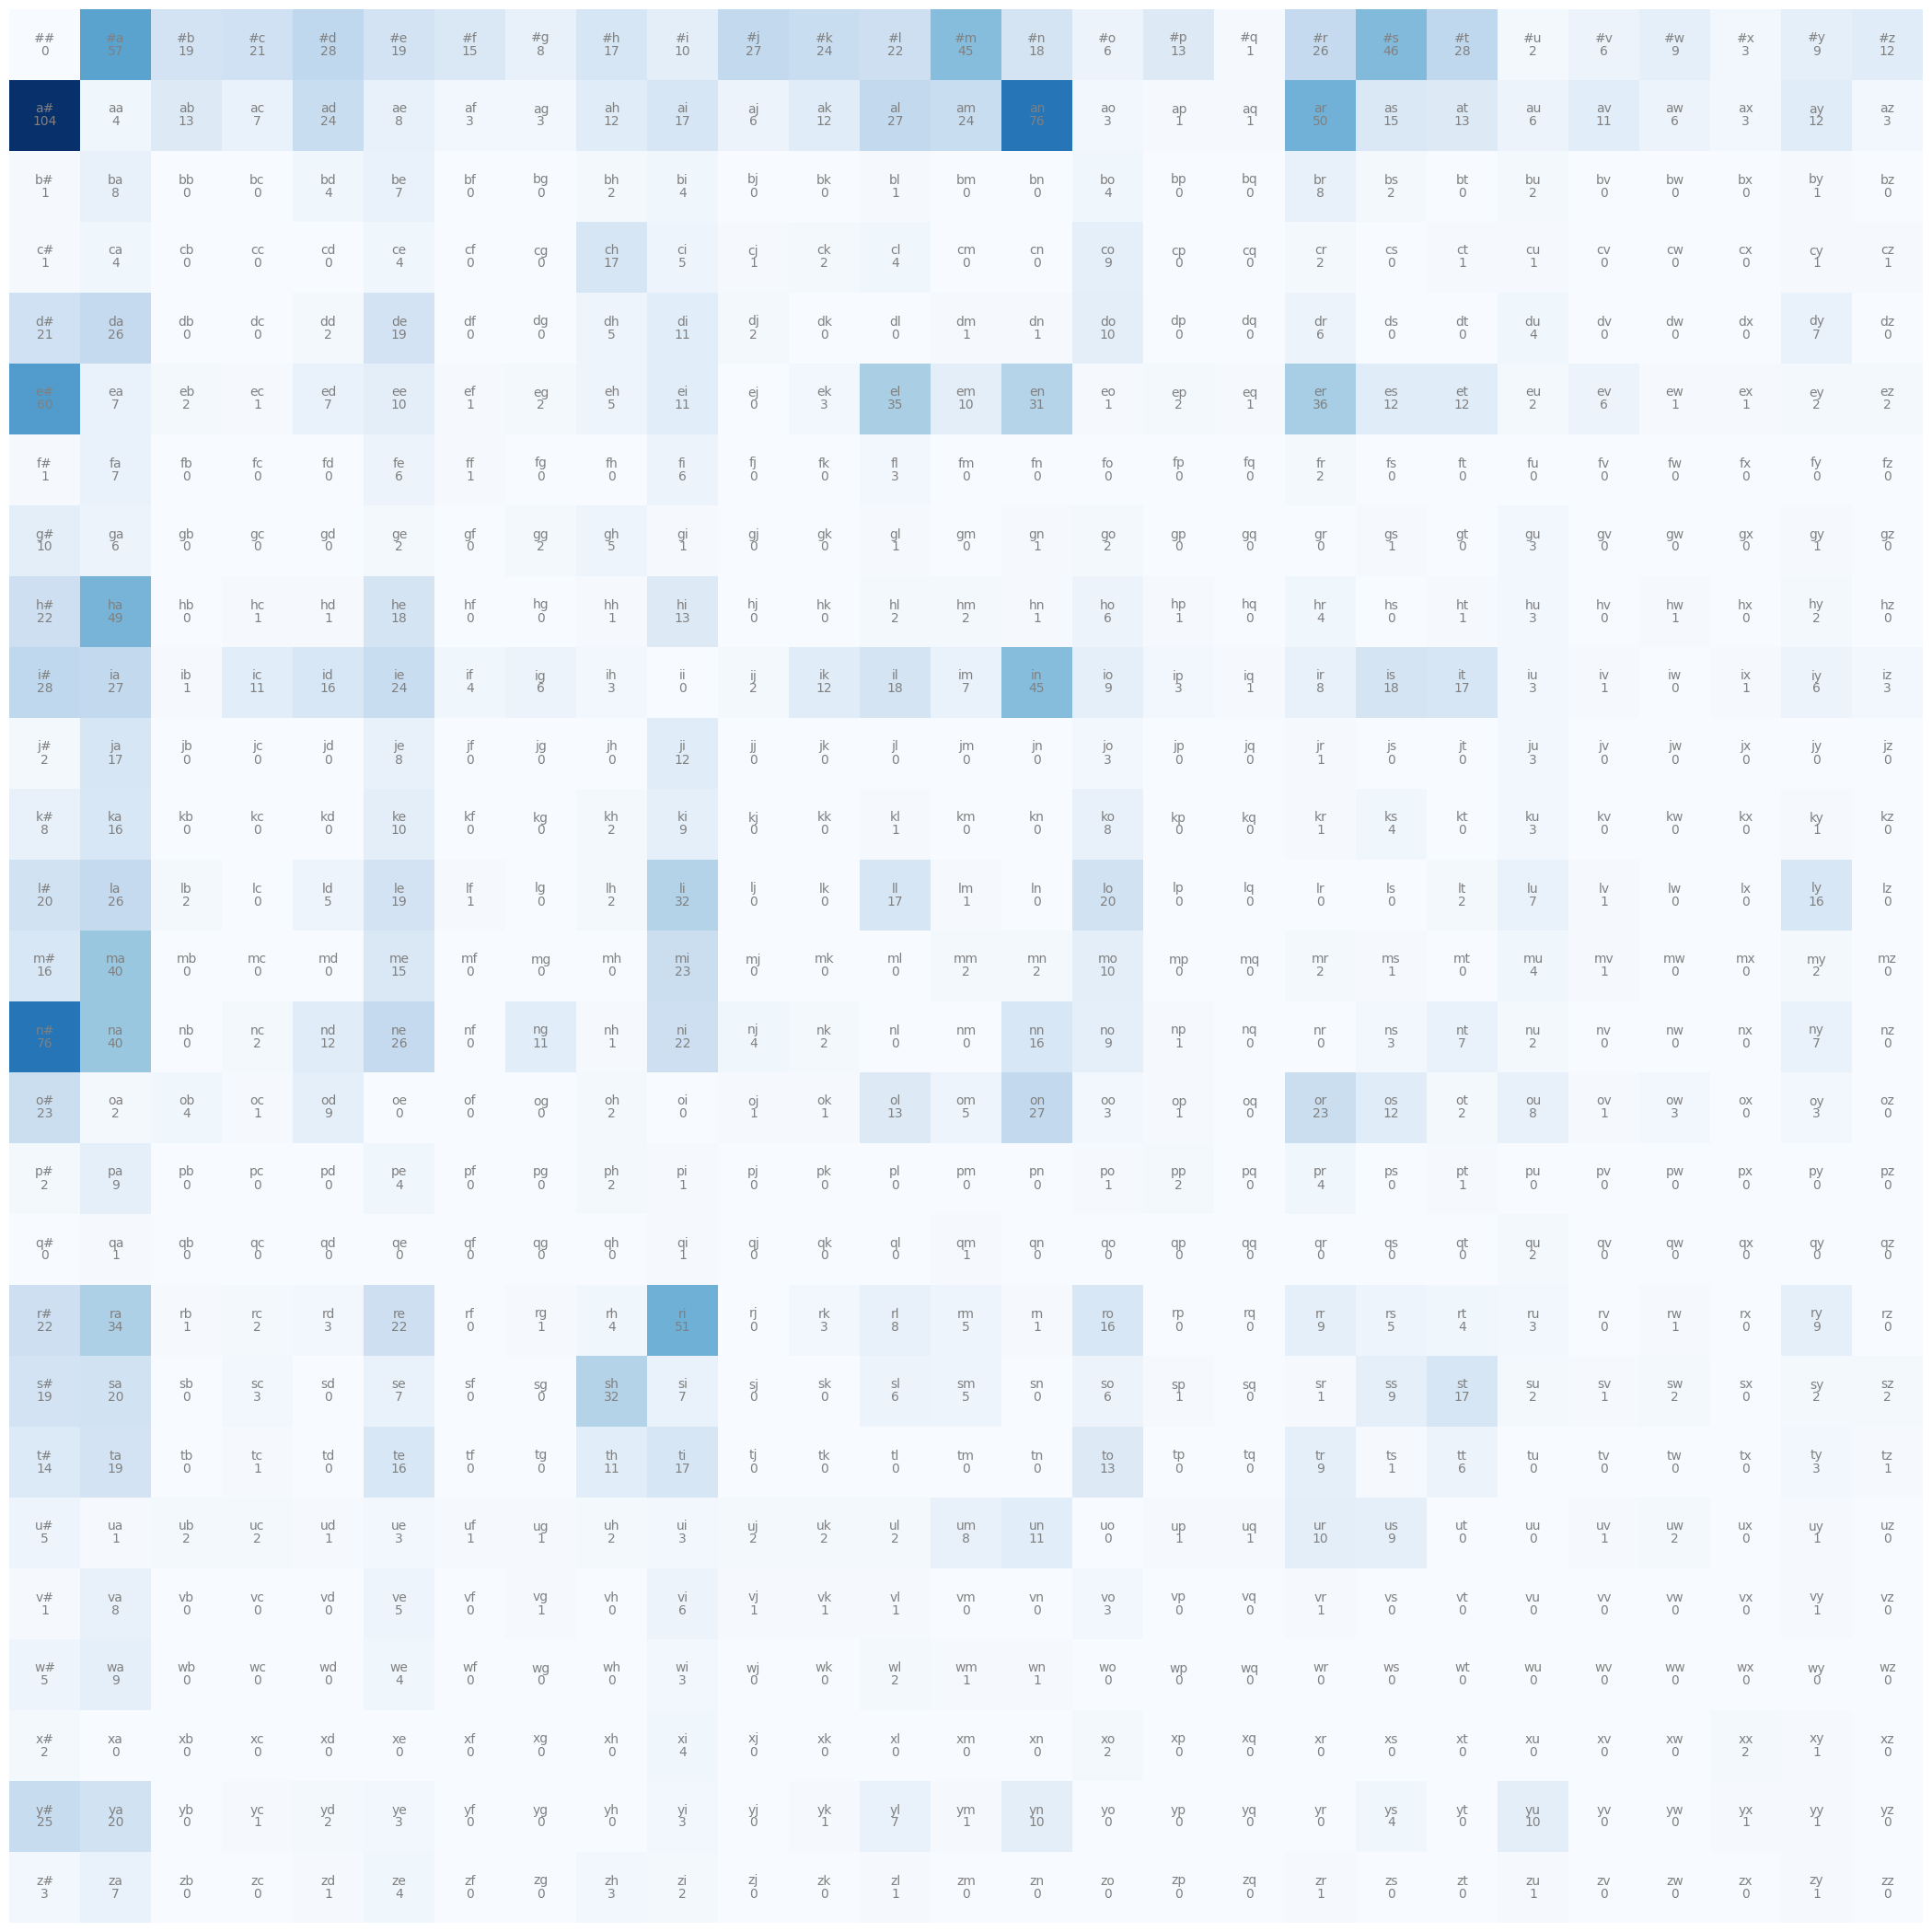

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(vocab_size, vocab_size))
plt.imshow(N, cmap='Blues')

for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")

plt.axis('off')




In [4]:
# Sampling the distribution
g = torch.Generator().manual_seed(2147483647)
P = (N+5).float()
P /= P.sum(1, keepdim=True)
for i in range(10):
    s = "#"
    while True:
        idx = stoi[s[-1]]
        cidx = torch.multinomial(P[idx], num_samples=1, replacement=True, generator=g).item()
        s += itos[cidx]
        if s[-1] == "#":
            print(s[1:-1])
            break

dexzmaloglkurkicqzktyhamvonimjttainjlkfakzka
da
staxvpubjtthrigotai
mozieqckvujiwpteda
ka
erkmmsadgu
tkavgyny
ftbspmhwcidenvtahlusu
dsdrxbanwglhpyaw
isan


In [38]:
# Model performance
log_likelihood = 0.0
for name in ["danielx"]: #names:
    for c1, c2 in zip(name, name[1:]):
        i1 = stoi[c1]
        i2 = stoi[c2]
        p = P[i1, i2]
        logprob = torch.log(p)
        log_likelihood += logprob
        nll = -log_likelihood
print(f"ll: {log_likelihood} nll: {nll}")


ll: -15.78017807006836 nll: 15.78017807006836


# Neural Net approach




In [39]:
import torch.nn.functional as F
xs, ys = [], []

for name in names:
    name = "#" + name + "#"
    for c1, c2 in zip(name, name[1:]):
        xs.append(stoi[c1])
        ys.append(stoi[c2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

W = torch.randn((27,27), requires_grad=True)
batch_size = len(xs)
print("HELLO")
for epoch in range(300):
    for (xb,yb) in zip(torch.split(xs, batch_size), torch.split(ys, batch_size)):
        if xb.shape[0] != batch_size:
            break
        xenc = F.one_hot(xb, num_classes=vocab_size).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        loss = -probs[torch.arange(batch_size), yb].log().mean() + 0.0*(W**2).mean()
        print(loss.item())
        W.grad = None
        loss.backward()
        W.data += -70 * W.grad



# sampling
# 

HELLO
3.757441997528076
3.2813031673431396
3.0573384761810303
2.9331133365631104
2.8521761894226074
2.7947564125061035
2.751668930053711
2.717954158782959
2.6907413005828857
2.668290376663208
2.649444341659546
2.6334035396575928
2.6195907592773438
2.6075832843780518
2.5970611572265625
2.587777853012085
2.5795392990112305
2.5721912384033203
2.5656068325042725
2.5596837997436523
2.554335832595825
2.5494906902313232
2.5450878143310547
2.541073799133301
2.5374040603637695
2.534039258956909
2.5309457778930664
2.528094530105591
2.525458812713623
2.5230159759521484
2.5207464694976807
2.518632173538208
2.5166573524475098
2.5148088932037354
2.5130743980407715
2.5114428997039795
2.5099053382873535
2.508453130722046
2.5070788860321045
2.5057764053344727
2.5045394897460938
2.5033628940582275
2.50224232673645
2.501173496246338
2.500152587890625
2.499176263809204
2.498241662979126
2.4973461627960205
2.496485948562622
2.4956610202789307
2.4948675632476807
2.4941043853759766
2.4933691024780273
2.49266

In [45]:
for sidx in range(4):
    s = "#"
    while True:
        xenc = F.one_hot(torch.tensor([stoi[s[-1]]]), num_classes=vocab_size).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(0, keepdim=True)
        output_char_idx = torch.multinomial(probs, num_samples=1, replacement=False).item()
        s += itos[output_char_idx]
        if s[-1] == "#":
            break
    print(s)

#shekbi#
#jovrpdhaizkxk#
#vpguysvnxvsmmsolycf#
#ye#
